In [1]:
!pip install findspark

In [3]:
#Importing important libraries
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Basic Python Libraries
import pandas as pd
import numpy as np

In [4]:
spark = SparkSession.builder \
        .appName("Retail Sales Data Analyzer") \
        .getOrCreate()
spark

In [6]:
file_path = "data/retail_sales.csv"

df = spark.read.option("header", True).option("inferSchema",True).csv(file_path)
df.show(5)

+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|   InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+
| 536365|   85123A|WHITE HANGING HEA...|       6|01/12/10 08:26| 2.55|      17850|United Kingdom|
| 536365|    71053| WHITE METAL LANTERN|       6|01/12/10 08:26| 3.39|      17850|United Kingdom|
| 536365|   84406B|CREAM CUPID HEART...|       8|01/12/10 08:26| 2.75|      17850|United Kingdom|
| 536365|   84029G|KNITTED UNION FLA...|       6|01/12/10 08:26| 3.39|      17850|United Kingdom|
| 536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/10 08:26| 3.39|      17850|United Kingdom|
+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+
only showing top 5 rows



In [9]:
df.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [11]:
# 1. Remove rows where important fields are null
df_clean = df.dropna(subset=["Invoice","Customer ID","Description","Price","Quantity"])

In [13]:
# 2. Convert InvoiceDate from string to Timestamp
df = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate","dd/MM/yy HH:mm"))

In [15]:
# 3. Remove negative quantities and prices
df = df.filter((df.Quantity > 0) & (df.Price > 0))

In [17]:
# 4. Rename column to remove spaces
df = df.withColumnRenamed("Customer ID","CustomerID")

In [19]:
# 5. Drop Duplicates
df = df.dropDuplicates()

In [21]:
df.show(5)

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
| 536389|    22727|ALARM CLOCK BAKEL...|       4|2010-12-01 10:03:00| 3.75|     12431|     Australia|
| 536398|    22835|HOT WATER BOTTLE ...|       8|2010-12-01 10:52:00| 4.65|     13448|United Kingdom|
| 536446|    22294|HEART FILIGREE DO...|      24|2010-12-01 12:15:00| 1.25|     15983|United Kingdom|
| 536464|    22619|SET OF 6 SOLDIER ...|       1|2010-12-01 12:23:00| 3.75|     17968|United Kingdom|
| 536464|    22945|CHRISTMAS METAL T...|       6|2010-12-01 12:23:00| 0.85|     17968|United Kingdom|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
only showing top 5 rows



## Data Exploration
#### We are performing basic analysis to gather insights and explore relationships in the data

In [24]:
df.show(10)

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
| 536389|    22727|ALARM CLOCK BAKEL...|       4|2010-12-01 10:03:00| 3.75|     12431|     Australia|
| 536398|    22835|HOT WATER BOTTLE ...|       8|2010-12-01 10:52:00| 4.65|     13448|United Kingdom|
| 536446|    22294|HEART FILIGREE DO...|      24|2010-12-01 12:15:00| 1.25|     15983|United Kingdom|
| 536464|    22619|SET OF 6 SOLDIER ...|       1|2010-12-01 12:23:00| 3.75|     17968|United Kingdom|
| 536464|    22945|CHRISTMAS METAL T...|       6|2010-12-01 12:23:00| 0.85|     17968|United Kingdom|
| 536538|    21143|ANTIQUE GLASS HEA...|       3|2010-12-01 13:54:00| 1.95|     14594|United Kingdom|
| 536557|    84920|PINK FLOWER FABRI...|       1|2010-12-01 14:41:00| 3.75|     17

In [28]:
print(f"Number of rows {df.count()}")

Number of rows 524879


In [36]:
df.describe().show()

+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|summary|           Invoice|         StockCode|         Description|          Quantity|             Price|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|  count|            524879|            524879|              524879|            524879|            524879|            392693|     524879|
|   mean| 559955.9321728097|27596.453561608865|                NULL|10.616582107495251|3.9225993876694005|15287.837223989223|       NULL|
| stddev|13418.293673426388| 16764.85351030406|                NULL|156.27988241440684| 36.09299838000089|1713.5424205624427|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|                 1|             0.001|             12346|  Australia|
|    max|           A563185|      

In [38]:
df.select("Country").distinct().show()

+---------------+
|        Country|
+---------------+
|         Sweden|
|      Singapore|
|        Germany|
|         France|
|         Greece|
|        Belgium|
|        Finland|
|          Italy|
|           EIRE|
|      Lithuania|
|         Norway|
|          Spain|
|        Denmark|
|      Hong Kong|
|        Iceland|
|         Israel|
|Channel Islands|
|         Cyprus|
|    Switzerland|
|        Lebanon|
+---------------+
only showing top 20 rows



In [75]:
df_group_country = df.groupBy("Country").agg( round(sum(col("Quantity")*col("Price")),4).alias("TotalSales")).orderBy("TotalSales",ascending=False)

In [77]:
df_group_country.show()

+---------------+-----------+
|        Country| TotalSales|
+---------------+-----------+
| United Kingdom|9001744.094|
|    Netherlands|  285446.34|
|           EIRE|  283140.52|
|        Germany|   228678.4|
|         France|  209643.37|
|      Australia|  138453.81|
|          Spain|   61558.56|
|    Switzerland|    57067.6|
|        Belgium|   41196.34|
|         Sweden|   38367.83|
|          Japan|   37416.37|
|         Norway|   36165.44|
|       Portugal|   33683.05|
|        Finland|   22546.08|
|      Singapore|   21279.29|
|Channel Islands|   20440.54|
|        Denmark|   18955.34|
|          Italy|   17483.24|
|      Hong Kong|    15483.0|
|         Cyprus|   13502.85|
+---------------+-----------+
only showing top 20 rows



In [81]:
df_grouped_customer = df.groupBy("CustomerID").agg(sum(col("Quantity")).alias("TotalQuantitySold")).orderBy("TotalQuantitySold",ascending=False)

In [83]:
df_grouped_customer.show()

+----------+-----------------+
|CustomerID|TotalQuantitySold|
+----------+-----------------+
|      NULL|           420418|
|     14646|           196915|
|     16446|            80997|
|     14911|            80240|
|     12415|            77374|
|     12346|            74215|
|     17450|            69973|
|     17511|            64549|
|     18102|            64124|
|     13694|            63312|
|     14298|            58343|
|     14156|            57768|
|     16684|            50255|
|     16029|            40108|
|     15311|            38147|
|     16422|            33704|
|     17404|            32748|
|     16333|            32184|
|     13089|            31025|
|     17949|            30546|
+----------+-----------------+
only showing top 20 rows



In [106]:
df_grouped_product = df.groupBy("StockCode","Description")\
                    .agg(round(sum(col("Quantity")*col("Price")),4)\
                    .alias("TotalProductSold"))\
                    .orderBy("TotalProductSold",ascending=False)

In [108]:
df_grouped_product.show()

+---------+--------------------+----------------+
|StockCode|         Description|TotalProductSold|
+---------+--------------------+----------------+
|      DOT|      DOTCOM POSTAGE|       206248.77|
|    22423|REGENCY CAKESTAND...|       174156.54|
|    23843|PAPER CRAFT , LIT...|        168469.6|
|   85123A|WHITE HANGING HEA...|       104284.24|
|    47566|       PARTY BUNTING|        99445.23|
|   85099B|JUMBO BAG RED RET...|        94159.81|
|    23166|MEDIUM CERAMIC TO...|        81700.92|
|     POST|             POSTAGE|        78119.88|
|        M|              Manual|        77750.27|
|    23084|  RABBIT NIGHT LIGHT|        66870.03|
|    22086|PAPER CHAIN KIT 5...|        64875.59|
|    84879|ASSORTED COLOUR B...|        58927.62|
|    79321|       CHILLI LIGHTS|        54096.36|
|    23298|      SPOTTY BUNTING|        42513.48|
|    22386|JUMBO BAG PINK PO...|        42401.01|
|    21137|BLACK RECORD COVE...|        40633.38|
|    22502|PICNIC BASKET WIC...|         39619.5|


In [97]:
df = df.withColumn("Month", month(df.InvoiceDate))
df = df.withColumn("Year", year(df.InvoiceDate))

df_grouped_month = df.groupBy("Month","Year").agg(round(sum(col("Quantity")*col("Price")),2).alias("MonthlySales")).orderBy("Year","Month")

In [99]:
df_grouped_month.show()

+-----+----+------------+
|Month|Year|MonthlySales|
+-----+----+------------+
|   12|2010|   821452.73|
|    1|2011|   689811.61|
|    2|2011|   522545.56|
|    3|2011|   716215.26|
|    4|2011|   536968.49|
|    5|2011|   769296.61|
|    6|2011|   760547.01|
|    7|2011|   718076.12|
|    8|2011|   757841.38|
|    9|2011|  1056435.19|
|   10|2011|  1151263.73|
|   11|2011|  1503866.78|
|   12|2011|   637808.33|
+-----+----+------------+



In [101]:
df_grouped_year = df.groupBy("Year").agg(round(sum(col("Quantity")*col("Price")),2).alias("YearlySales")).orderBy("Year")

In [103]:
df_grouped_year.show()

+----+-----------+
|Year|YearlySales|
+----+-----------+
|2010|  821452.73|
|2011| 9820676.07|
+----+-----------+



## Analytics
#### Summarizing the dataset or performing business-specific analysis

In [114]:
df_revenue_per_customer = df.groupBy("CustomerID").agg(round(sum(col("Quantity")*col("Price")),2).alias("RevenuePerCustomer")).orderBy("RevenuePerCustomer",ascending=False)

In [116]:
df_revenue_per_customer.show()

+----------+------------------+
|CustomerID|RevenuePerCustomer|
+----------+------------------+
|      NULL|        1754901.91|
|     14646|         280206.02|
|     18102|          259657.3|
|     17450|         194390.79|
|     16446|          168472.5|
|     14911|         143711.17|
|     12415|         124914.53|
|     14156|         117210.08|
|     17511|          91062.38|
|     16029|          80850.84|
|     12346|           77183.6|
|     16684|          66653.56|
|     14096|          65164.79|
|     13694|          65039.62|
|     15311|          60632.75|
|     13089|          58762.08|
|     17949|          58510.48|
|     15769|          56252.72|
|     15061|          54534.14|
|     14298|           51527.3|
+----------+------------------+
only showing top 20 rows



In [118]:
df_top_products = df.groupBy("StockCode","Description").agg(round(sum(col("Quantity")*col("price")),2).alias("Revenue")).orderBy("Revenue",ascending=False)

In [120]:
df_top_products.show()

+---------+--------------------+---------+
|StockCode|         Description|  Revenue|
+---------+--------------------+---------+
|      DOT|      DOTCOM POSTAGE|206248.77|
|    22423|REGENCY CAKESTAND...|174156.54|
|    23843|PAPER CRAFT , LIT...| 168469.6|
|   85123A|WHITE HANGING HEA...|104284.24|
|    47566|       PARTY BUNTING| 99445.23|
|   85099B|JUMBO BAG RED RET...| 94159.81|
|    23166|MEDIUM CERAMIC TO...| 81700.92|
|     POST|             POSTAGE| 78119.88|
|        M|              Manual| 77750.27|
|    23084|  RABBIT NIGHT LIGHT| 66870.03|
|    22086|PAPER CHAIN KIT 5...| 64875.59|
|    84879|ASSORTED COLOUR B...| 58927.62|
|    79321|       CHILLI LIGHTS| 54096.36|
|    23298|      SPOTTY BUNTING| 42513.48|
|    22386|JUMBO BAG PINK PO...| 42401.01|
|    21137|BLACK RECORD COVE...| 40633.38|
|    22502|PICNIC BASKET WIC...|  39619.5|
|    23284|DOORMAT KEEP CALM...| 38133.64|
|    22720|SET OF 3 CAKE TIN...| 38108.89|
|    22960|JAM MAKING SET WI...| 37082.13|
+---------+

In [168]:
df_sales_by_country = df.groupBy("Country").agg(round(sum(col("Quantity")*col("Price")),2).alias("TotalRevenue")).orderBy("Country",ascending=True)

In [170]:
df_sales_by_country.show()

+------------------+------------+
|           Country|TotalRevenue|
+------------------+------------+
|         Australia|   138453.81|
|           Austria|    10198.68|
|           Bahrain|      754.14|
|           Belgium|    41196.34|
|            Brazil|      1143.6|
|            Canada|     3666.38|
|   Channel Islands|    20440.54|
|            Cyprus|    13502.85|
|    Czech Republic|      826.74|
|           Denmark|    18955.34|
|              EIRE|   283140.52|
|European Community|     1300.25|
|           Finland|    22546.08|
|            France|   209643.37|
|           Germany|    228678.4|
|            Greece|     4760.52|
|         Hong Kong|     15483.0|
|           Iceland|      4310.0|
|            Israel|     8129.41|
|             Italy|    17483.24|
+------------------+------------+
only showing top 20 rows



In [142]:
df_avg_price = df.groupBy("StockCode","Description").agg((round(sum(col("Quantity")*col("Price"))/sum(col("Quantity")),2)).alias("AveragePricePerProduct")).orderBy("StockCode","Description",ascending=False)

In [144]:
df_avg_price.show()

+------------+--------------------+----------------------+
|   StockCode|         Description|AveragePricePerProduct|
+------------+--------------------+----------------------+
|           m|              Manual|                  2.55|
|gift_0001_50|Dotcomgiftshop Gi...|                 41.89|
|gift_0001_40|Dotcomgiftshop Gi...|                 33.57|
|gift_0001_30|Dotcomgiftshop Gi...|                 25.08|
|gift_0001_20|Dotcomgiftshop Gi...|                 16.71|
|gift_0001_10|Dotcomgiftshop Gi...|                  8.33|
|           S|             SAMPLES|                 31.53|
|        POST|             POSTAGE|                 24.79|
|        PADS|PADS TO MATCH ALL...|                   0.0|
|           M|              Manual|                 11.13|
|         DOT|      DOTCOM POSTAGE|                292.14|
|   DCGSSGIRL|     GIRLS PARTY BAG|                  3.07|
|    DCGSSBOY|      BOYS PARTY BAG|                   3.2|
|    DCGS0076|SUNJAR LED NIGHT ...|                 16.1

## Visualization
#### A great way to present the data into graphical format

In [148]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [162]:
df.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



C:\Users\Prince\AppData\Local\Temp\ipykernel_25524\3244413945.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="TotalRevenue", y="Country", data=df_country_pd, palette="viridis")


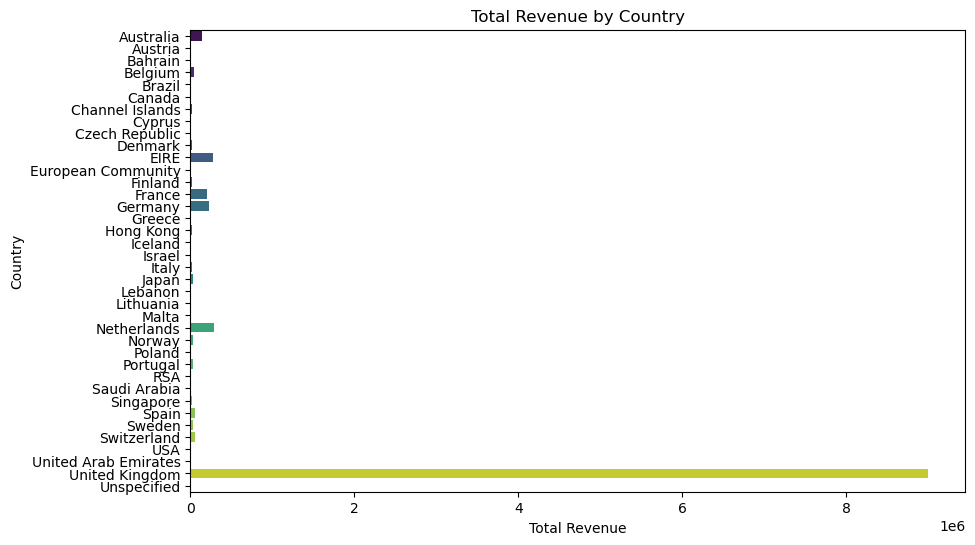

<Figure size 640x480 with 0 Axes>

In [242]:
import matplotlib.pyplot as plt
import seaborn as sns

df_country_pd = df_sales_by_country.toPandas()
# df_country_pd

plt.figure(figsize=(10,6))
sns.barplot(x="TotalRevenue", y="Country", data=df_country_pd, palette="viridis")
plt.title("Total Revenue by Country")
plt.xlabel("Total Revenue")
plt.ylabel("Country")
plt.show()

plt.savefig('outputs/Total_Revenue_by_Country.png', bbox_inches='tight', dpi=300)

C:\Users\Prince\AppData\Local\Temp\ipykernel_25524\463608582.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Month", y="MonthlySales", data=df_monthly_sales_pd, palette="viridis")


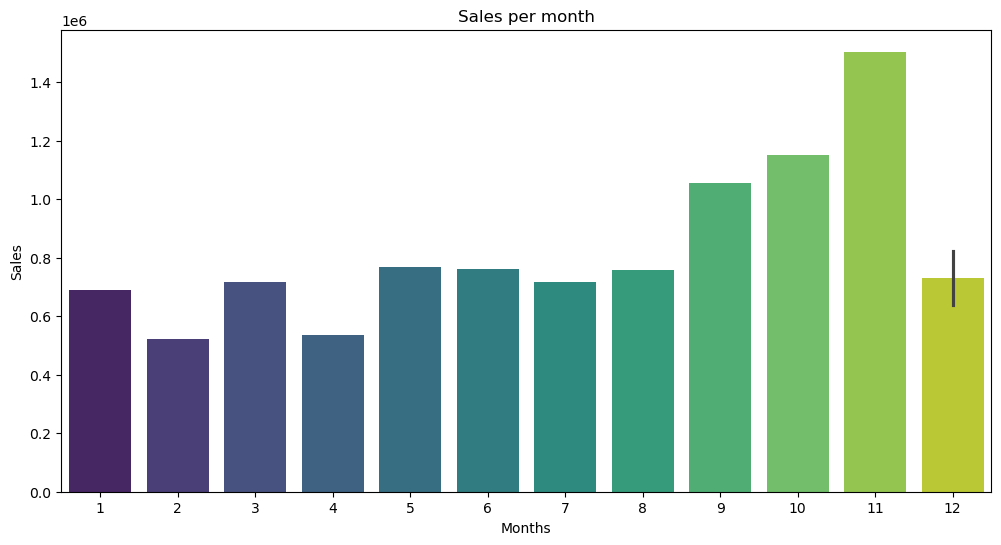

<Figure size 640x480 with 0 Axes>

In [244]:
df_monthly_sales_pd = df_grouped_month.toPandas()
df_grouped_month

plt.figure(figsize=(12,6))
sns.barplot(x="Month", y="MonthlySales", data=df_monthly_sales_pd, palette="viridis")
plt.title("Sales per month")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.show()
plt.savefig('outputs/Sales_per_Month.png', bbox_inches='tight', dpi=300)

C:\Users\Prince\AppData\Local\Temp\ipykernel_25524\21757966.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Description", y="Revenue", data=df_top_products_pd, palette="viridis")


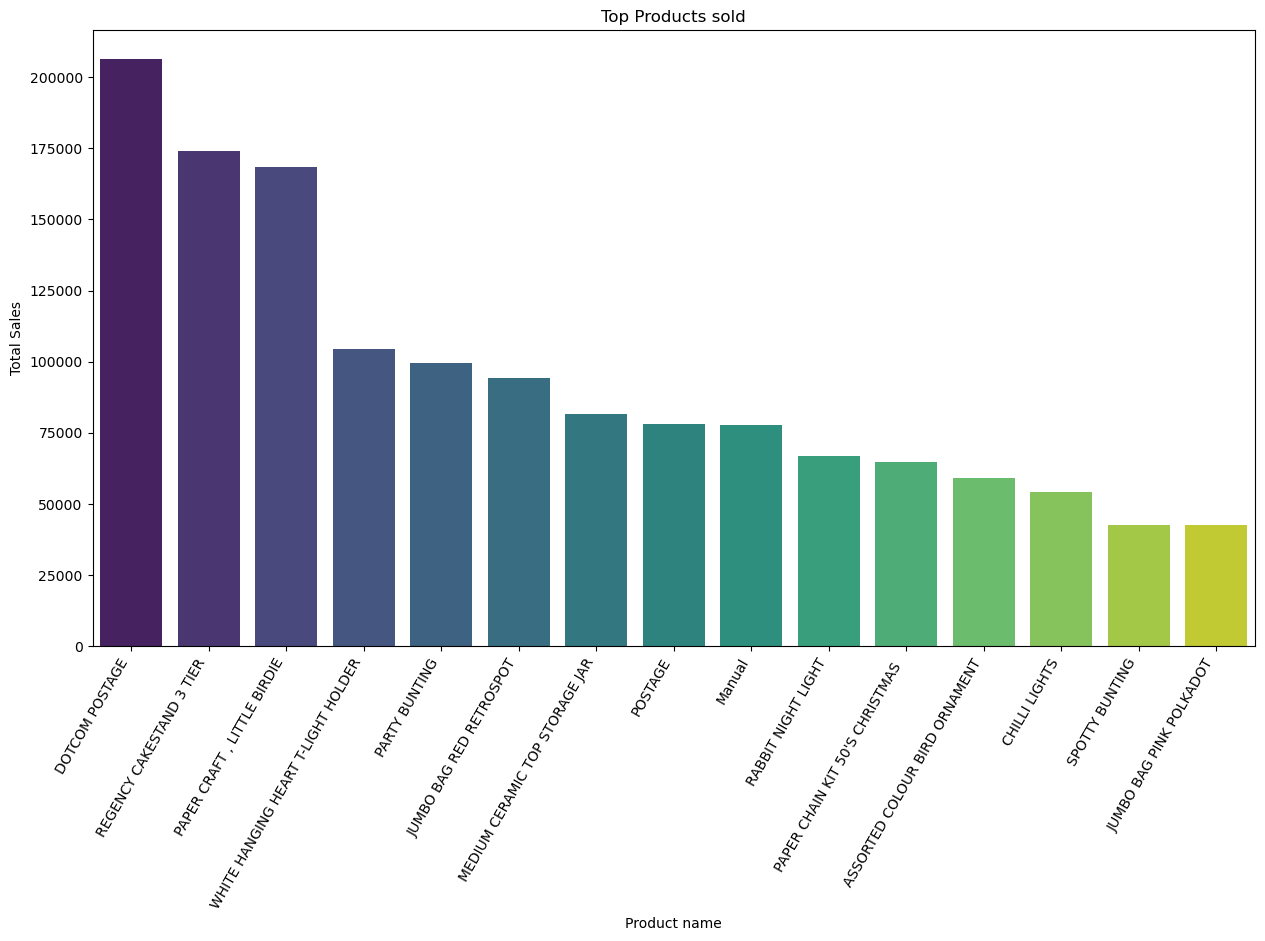

<Figure size 640x480 with 0 Axes>

In [246]:
df_top_products_pd = df_top_products.limit(15).toPandas()
df_top_products_pd

plt.figure(figsize=(15,8))
sns.barplot(x="Description", y="Revenue", data=df_top_products_pd, palette="viridis")
plt.title("Top Products sold")
plt.xticks(rotation=60, ha='right')
plt.xlabel("Product name")
plt.ylabel("Total Sales")
plt.show()
plt.savefig('outputs/Top_Products_Sold.png', bbox_inches='tight', dpi=300)

In [236]:
df_country_pd.to_csv('outputs/Total_Revenue_by_Country.csv',index=False)

In [238]:
df_monthly_sales_pd.to_csv('outputs/Sales_per_month.csv', index=False)

In [240]:
df_top_products_pd.to_csv('outputs/Top_Products_Revenue.csv', index=False)